# New York City Taxi Fare Predictions

#### Team members:

1. Tejaswini Pradip Srivastava - tps7866
2. Pranav Nitin Motarwar - pm3891
3. Subhiksha - ssn9077

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from haversine import haversine, Unit
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_path = 'new-york-city-taxi-fare-prediction/train.csv'  
test_path ='new-york-city-taxi-fare-prediction/test.csv'

train = pd.read_csv(train_path, nrows = 100000, parse_dates=["pickup_datetime"])
test = pd.read_csv(test_path)

## Exploring the dataset

In [3]:
print(train.shape)
print(test.shape)

(100000, 8)
(9914, 7)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                100000 non-null  object             
 1   fare_amount        100000 non-null  float64            
 2   pickup_datetime    100000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   100000 non-null  float64            
 4   pickup_latitude    100000 non-null  float64            
 5   dropoff_longitude  100000 non-null  float64            
 6   dropoff_latitude   100000 non-null  float64            
 7   passenger_count    100000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 6.1+ MB


In [5]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [6]:
train.dtypes

key                               object
fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [7]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.354652,-72.494682,39.914481,-72.490967,39.919053,1.673820
std,9.716777,10.693934,6.225686,10.471386,6.213427,1.300171
min,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992041,40.734996,-73.991215,40.734182,1.000000
50%,8.500000,-73.981789,40.752765,-73.980000,40.753243,1.000000
75%,12.500000,-73.966982,40.767258,-73.963433,40.768166,2.000000
max,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000


## Data Cleaning and Feature Engineering

In this section we will be removing empty values, removing outliers , removing fares that are negative or excessively high, removing unrealistic latitudes and longitudes etc in order to clean the dataset.

In [8]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [9]:
train = train[(train['fare_amount'] > 0) & (train['fare_amount'] < 200)]

In [10]:
train = train[(train['pickup_latitude'].between(40.5, 41)) & 
        (train['pickup_longitude'].between(-74.5, -73.5)) & 
        (train['dropoff_latitude'].between(40.5, 41)) & 
        (train['dropoff_longitude'].between(-74.5, -73.5))]

Extracting features

In [11]:
for df in [train, test]:
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
    df['year'] = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day'] = df['pickup_datetime'].dt.day
    df['hour'] = df['pickup_datetime'].dt.hour
    df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
    df['minute'] =df['pickup_datetime'].dt.minute
    df['second'] = df['pickup_datetime'].dt.second
    df['dayofyear'] = df['pickup_datetime'].dt.dayofyear

Calculating distance using haversine formula

In [12]:
def calculate_distance(row):
    pickup = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
    return haversine(pickup, dropoff,unit=Unit.MILES)

In [13]:
train['distance_miles'] = train.apply(calculate_distance, axis=1)
test['distance_miles'] = test.apply(calculate_distance, axis=1)

Dropping rows with zero or very small distances

In [14]:
train = train[train['distance_miles'] > 0.1]
test = test[test['distance_miles'] > 0.1]

Remove rides where start and end points match

In [15]:
train = train[
    (train['pickup_latitude'] != train['dropoff_latitude']) |
    (train['pickup_longitude'] != train['dropoff_longitude'])
]

Removing extreme outliers in fare_amount or distance

In [16]:
train = train[train['fare_amount'] < (train['fare_amount'].mean() + 3 * train['fare_amount'].std())]

In [17]:
train.shape

(93422, 17)

In [18]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,day_of_week,minute,second,dayofyear,distance_miles
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17,0,26,21,166,0.640488
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16,1,52,16,5,5.250677
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,0,3,35,0,230,0.863412
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,4,5,30,42,112,1.739388
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,7,1,51,0,68,1.242220


## Visualising the dataset

#### Distribution of taxi fares

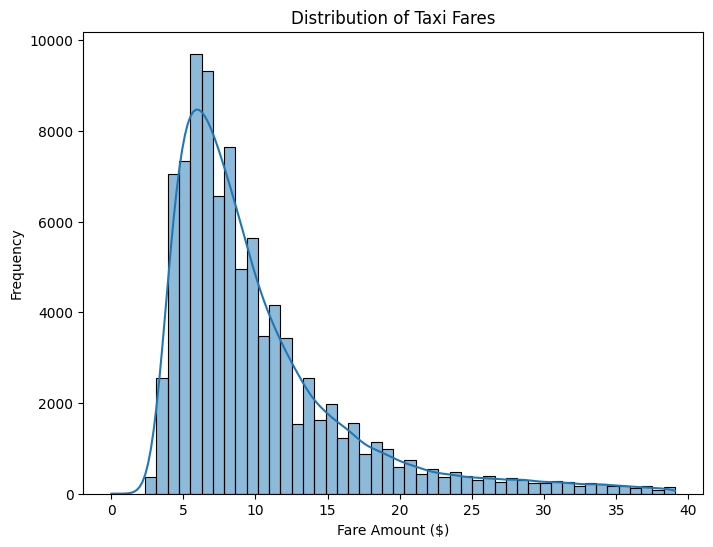

In [19]:

plt.figure(figsize=(8, 6))
sns.histplot(train['fare_amount'], kde=True, bins=50)
plt.title('Distribution of Taxi Fares')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Frequency')
plt.show()

The histogram shows that taxi fares are predominantly concentrated between **$5 and $15**, with a peak (mode) around **$6 to $7**, indicating that most rides are short to medium distances. The distribution is heavily **right-skewed**, with fewer rides as the fare increases, and a long tail representing occasional high fares, likely for longer or special-purpose trips like airport transfers. This suggests that predictive models should account for the skewness and potential outliers to improve accuracy.

#### Relationship between distance and fare

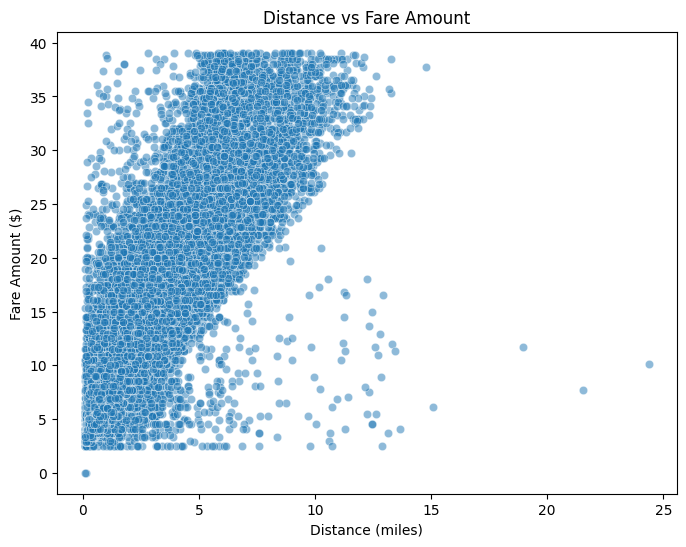

In [20]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train, x='distance_miles', y='fare_amount', alpha=0.5)
plt.title('Distance vs Fare Amount')
plt.xlabel('Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.show()

This scatter plot illustrates the relationship between **distance (miles)** and **fare amount ($)** for taxi rides. There is a clear positive correlation: **as the distance increases, the fare generally increases**. However, the plot shows significant variability for shorter distances (0–5 miles), where fares range widely, likely due to factors such as traffic, time of day, or minimum fare policies. 

#### Count of rides by hour

/var/folders/1n/z5ghbpl56w9_6wk68x5pv9gw0000gn/T/ipykernel_30151/1814979905.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hour', data=train, palette='viridis')


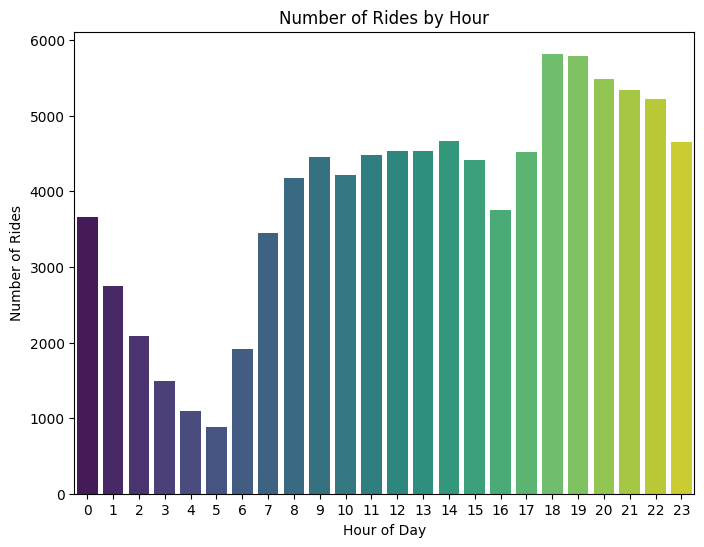

In [21]:

plt.figure(figsize=(8, 6))
sns.countplot(x='hour', data=train, palette='viridis')
plt.title('Number of Rides by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.show()

This bar plot illustrates the **number of rides by hour of the day**. The ride count is lowest during the early morning hours (3–5 AM) and steadily increases starting at 6 AM, likely due to morning commutes. The number of rides peaks during evening hours (6–9 PM), corresponding to post-work travel and other activities, before gradually decreasing late at night. This pattern reflects typical daily human activity and transportation demand.

#### Average fare by day of the week

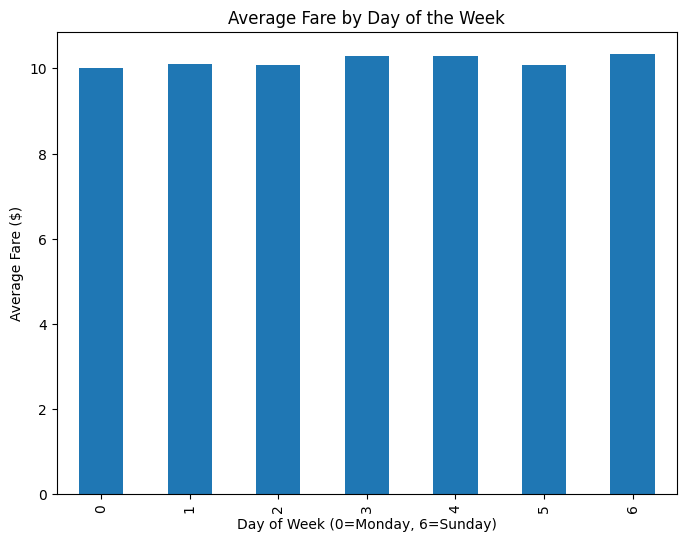

In [22]:
plt.figure(figsize=(8, 6))
avg_fare_by_day = train.groupby('day_of_week')['fare_amount'].mean()
avg_fare_by_day.plot(kind='bar')
plt.title('Average Fare by Day of the Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Fare ($)')
plt.show()

The average fare remains fairly consistent across all days, with no significant variations. This indicates that taxi fare pricing is relatively stable throughout the week, suggesting that factors like distance or time of travel may have a more substantial influence on fares than the day of the week.

#### Average Fare by Number of Passengers

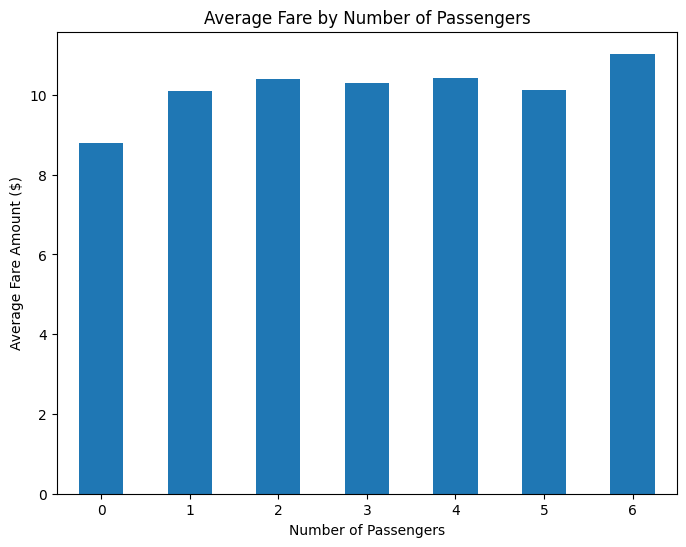

In [23]:
plt.figure(figsize=(8, 6))
passenger_fare = train.groupby('passenger_count')['fare_amount'].mean()
passenger_fare.plot(kind='bar')
plt.title('Average Fare by Number of Passengers')
plt.xlabel('Number of Passengers')
plt.ylabel('Average Fare Amount ($)')
plt.xticks(rotation=0)
plt.show()


This bar plot illustrates the **average fare amount by the number of passengers**. While the average fare increases slightly as the number of passengers increases, the variation is minimal, with fares remaining relatively stable for different passenger counts. This suggests that fare amounts are primarily influenced by trip distance and other factors rather than the number of passengers. The slightly higher average fare for six passengers may reflect larger group trips or rides requiring larger vehicles.

#### Heatmap for the effect of pick-up date and time

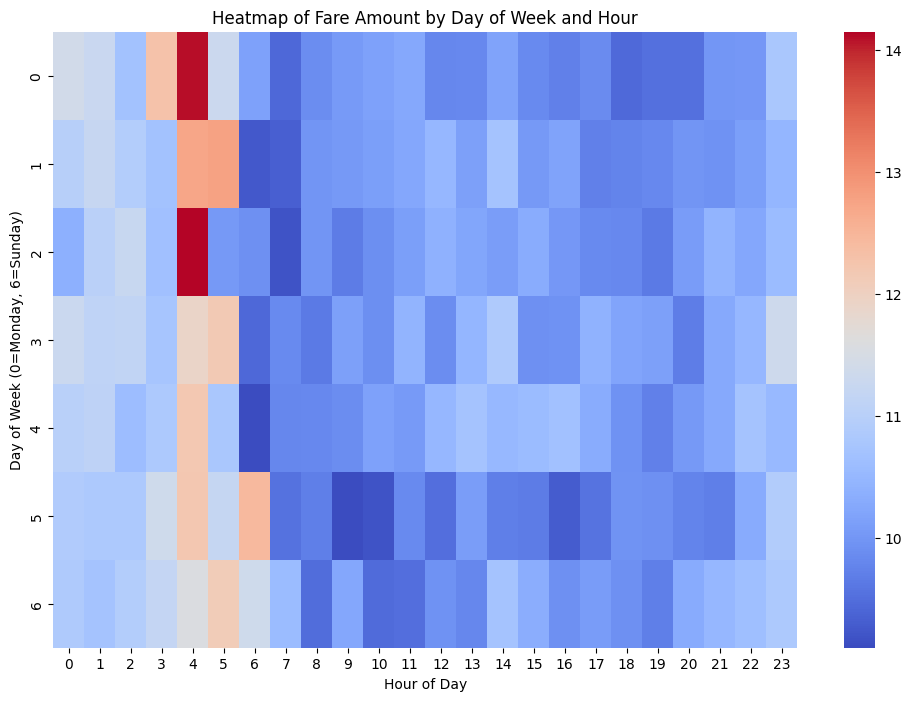

In [24]:
train['hour'] = train['pickup_datetime'].dt.hour
train['day_of_week'] = train['pickup_datetime'].dt.dayofweek
heatmap_data = train.groupby(['day_of_week', 'hour'])['fare_amount'].mean().unstack()
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=False, cmap='coolwarm')
plt.title('Heatmap of Fare Amount by Day of Week and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (0=Monday, 6=Sunday)')
plt.show()

This heatmap shows the **average fare amount** by the **day of the week (y-axis)** and the **hour of the day (x-axis)**. Higher fares are observed during **early morning hours (4-6 AM)** on weekdays (especially Tuesday and Wednesday), likely due to airport rides or early commutes. The fares are relatively consistent throughout the rest of the day and week, with no significant peaks in the late evening or weekends. This indicates that temporal factors such as early morning weekday trips might drive higher fare amounts.

####  Line plots of fare amount by different time features

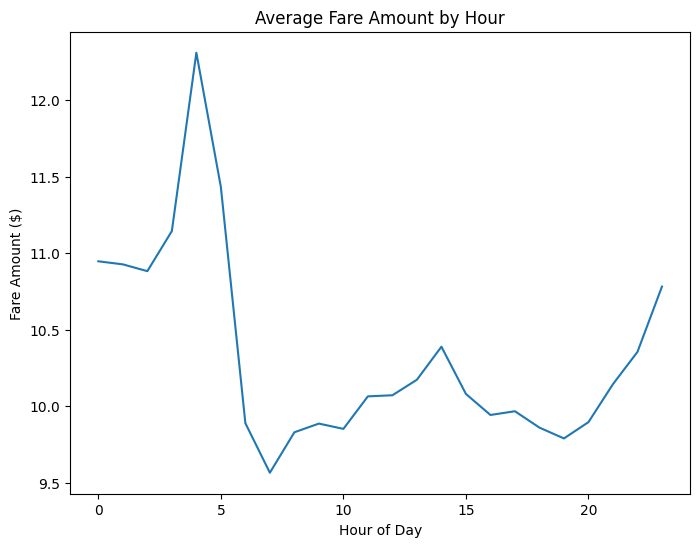

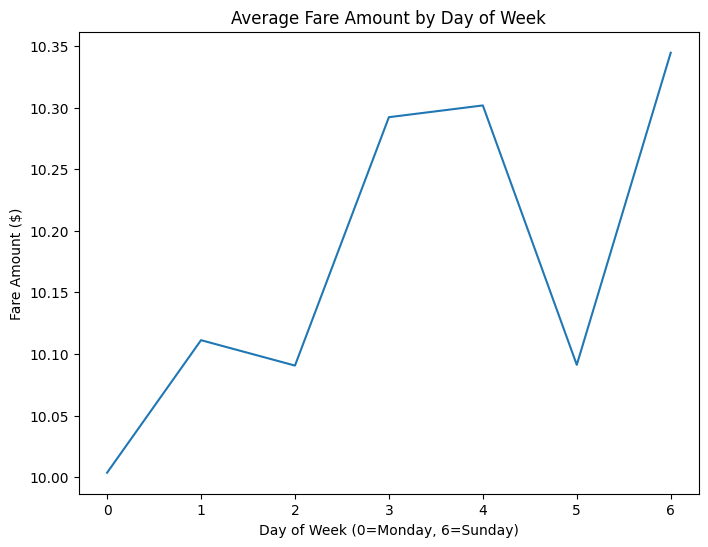

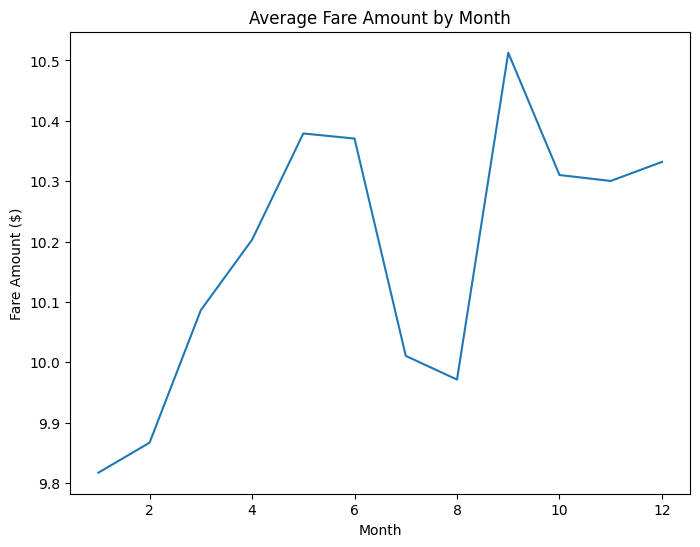

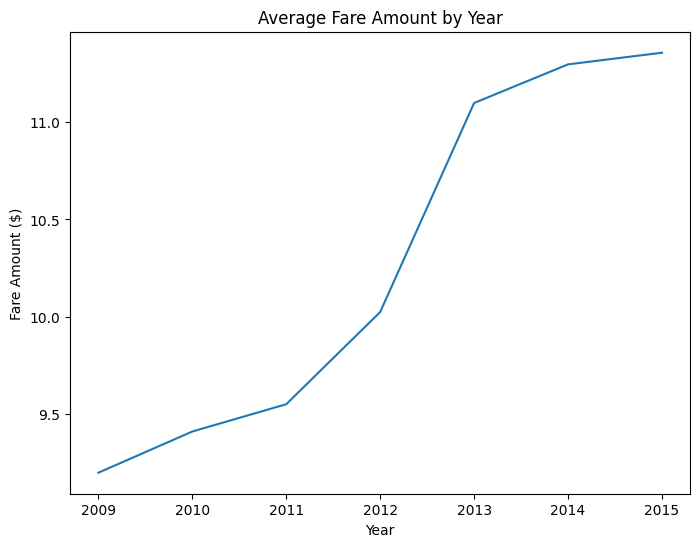

In [25]:
# By hour
plt.figure(figsize=(8, 6))
train.groupby('hour')['fare_amount'].mean().plot(kind='line')
plt.title('Average Fare Amount by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Fare Amount ($)')
plt.show()

# By day of week
plt.figure(figsize=(8, 6))
train.groupby('day_of_week')['fare_amount'].mean().plot(kind='line')
plt.title('Average Fare Amount by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Fare Amount ($)')
plt.show()

# By month
if 'month' in train.columns:
    plt.figure(figsize=(8, 6))
    train.groupby('month')['fare_amount'].mean().plot(kind='line')
    plt.title('Average Fare Amount by Month')
    plt.xlabel('Month')
    plt.ylabel('Fare Amount ($)')
    plt.show()

# By year
if 'year' in train.columns:
    plt.figure(figsize=(8, 6))
    train.groupby('year')['fare_amount'].mean().plot(kind='line')
    plt.title('Average Fare Amount by Year')
    plt.xlabel('Year')
    plt.ylabel('Fare Amount ($)')
    plt.show()



The analysis reveals that **average fares peak early morning (4–5 AM)**, likely due to airport trips, and drop during the day. Weekly trends are stable, with slightly higher fares on Sundays, possibly for leisure or travel. Seasonally, fares peak in **spring and summer (April–July)**, likely driven by tourism, and drop in August. Over the years, fares steadily increased from **2009 to 2014**, reflecting inflation or policy changes, before stabilizing. Time of day and season significantly influence fares, while weekly patterns remain consistent.

#### USD per mile for each ride

Calculated Average $USD/mile: 7.10


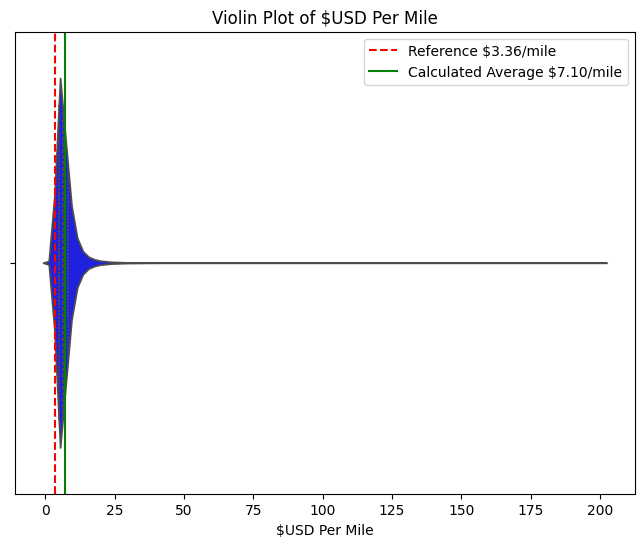

In [26]:
train['usd_per_mile'] = train['fare_amount'] / train['distance_miles']
train = train.replace([np.inf, -np.inf], np.nan).dropna(subset=['usd_per_mile'])
average_usd_per_mile = train['usd_per_mile'].mean()
print(f"Calculated Average $USD/mile: {average_usd_per_mile:.2f}")

plt.figure(figsize=(8, 6))
sns.violinplot(x=train['usd_per_mile'], color='blue', inner='quartile', orient='h')
plt.axvline(x=3.36, color='red', linestyle='--', label='Reference $3.36/mile')
plt.axvline(x=average_usd_per_mile, color='green', linestyle='-', label=f'Calculated Average ${average_usd_per_mile:.2f}/mile')
plt.title('Violin Plot of $USD Per Mile')
plt.xlabel('$USD Per Mile')
plt.legend()
plt.show()

This violin plot illustrates the distribution of **$USD per mile** for taxi rides, with the **reference value ($3.36/mile)** marked in red and the **calculated average ($7.10/mile)** in green. The plot reveals a highly skewed distribution, with most values concentrated near the lower end, close to the reference value. The long tail suggests the presence of outliers with extremely high per-mile costs, which may indicate short trips with minimum fare policies or unusual pricing anomalies. Further preprocessing might be needed to address these outliers.

## Data Preprocessing

In [27]:
features = ['distance_miles', 'hour', 'day_of_week', 'month', 'year', 'passenger_count']
scaler = StandardScaler()
train[features] = scaler.fit_transform(train[features])
test[features] = scaler.transform(test[features])

/var/folders/1n/z5ghbpl56w9_6wk68x5pv9gw0000gn/T/ipykernel_30151/3762925.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[features] = scaler.transform(test[features])


In [28]:
X = train[features]
y = train['fare_amount']
X_test = test[features] 

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

## Model training and Validation

We are using 5 diffrenet models to train thi data - **Linear Regression, Ridge Regression, Decision Tree Classifier, Random Forest Generator, Gradient Boosting Regressor** 

In [30]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

In [31]:
results = []

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    # Predicting on validation set
    y_valid_pred = model.predict(X_valid)
    # Computing evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
    mae = mean_absolute_error(y_valid, y_valid_pred)
    r2 = r2_score(y_valid, y_valid_pred)

    results.append({'Model': name, 'RMSE': rmse, 'MAE': mae, 'R2': r2})


In [32]:
results_df = pd.DataFrame(results)
results_df.head()

,Model,RMSE,MAE,R2
0,Linear Regression,3.106605,1.923588,0.760857
1,Ridge Regression,3.106603,1.923592,0.760857
2,Decision Tree,3.936582,2.524066,0.616006
3,Random Forest,2.813320,1.813243,0.803879
4,Gradient Boosting,2.718428,1.720265,0.816886


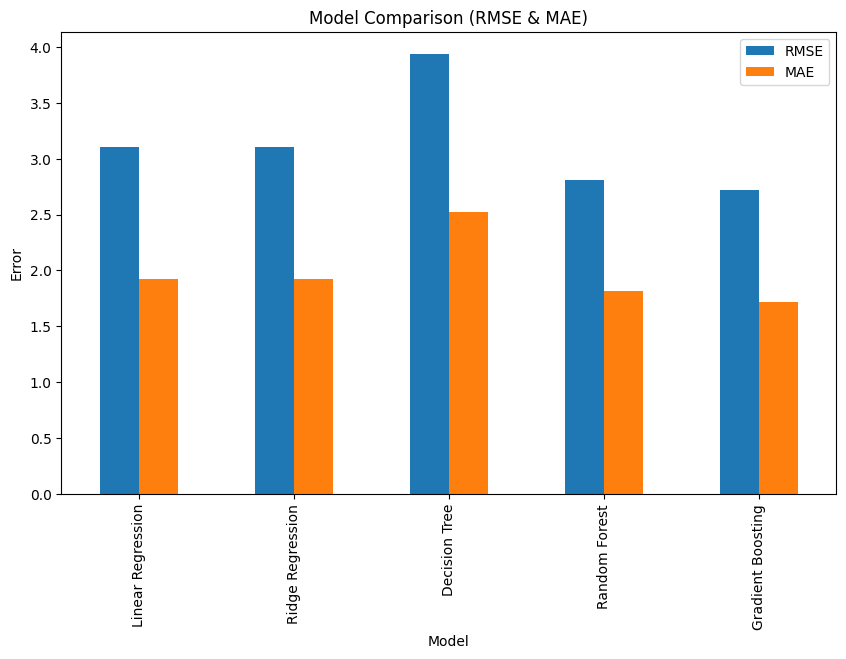

In [33]:
results_df.set_index('Model', inplace=True)
results_df[['RMSE', 'MAE']].plot(kind='bar', figsize=(10, 6), title='Model Comparison (RMSE & MAE)')
plt.ylabel('Error')
plt.show()

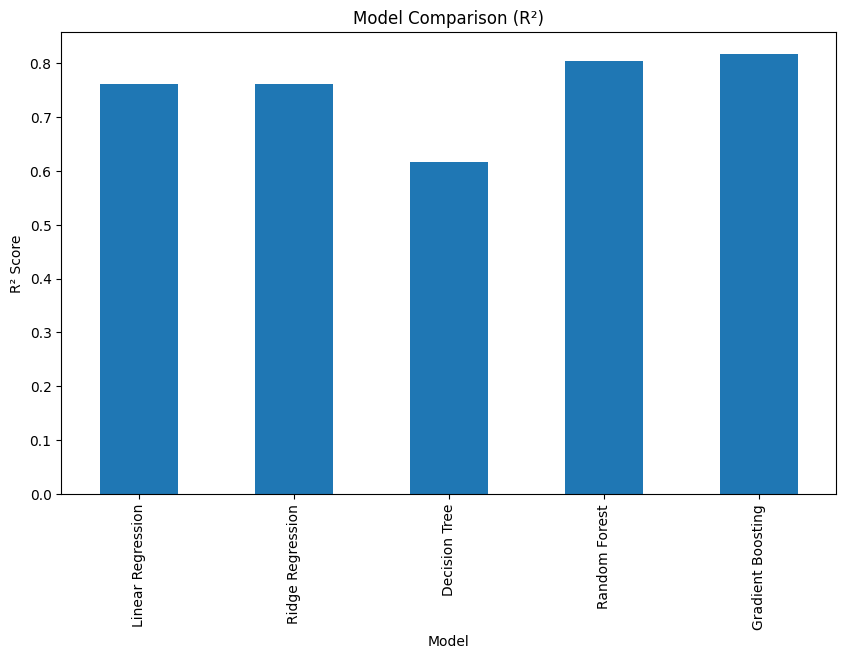

In [34]:
# Bar plot for R²
results_df['R2'].plot(kind='bar', figsize=(10, 6), title='Model Comparison (R²)')
plt.ylabel('R² Score')
plt.show()


The **Gradient Boosting model** performs the best with the lowest RMSE (2.72) and MAE (1.72) and the highest R² (0.8169), indicating it explains ~81.7% of the variance in fare predictions. Random Forest is a close second with slightly higher RMSE and MAE but a strong R² (0.8039). Linear and Ridge Regression show similar performance, while Decision Tree performs the worst, with the highest errors and the lowest R² (0.614). The results are consistent with expectations, as ensemble models like Gradient Boosting and Random Forest generally perform better on such tasks.

In [35]:
for name, model in models.items():
    test_predictions = model.predict(X_test)
    print(f"{name} Test Predictions (Sample): {test_predictions[:5]}")

Linear Regression Test Predictions (Sample): [ 9.9901326  10.20680898  4.91497636  8.47291257 15.74460755]
Ridge Regression Test Predictions (Sample): [ 9.99013322 10.20680667  4.91504919  8.47293167 15.74452843]
Decision Tree Test Predictions (Sample): [10.5 13.   3.7  8.  20.9]
Random Forest Test Predictions (Sample): [10.195 11.17   4.684  8.415 16.205]
Gradient Boosting Test Predictions (Sample): [10.54415125 10.83508551  4.492253    8.10220886 15.18015402]


These results show sample predictions from the test dataset for each model. The predictions are similar across models for most test instances, with slight variations. Ensemble models like **Random Forest** and **Gradient Boosting** provide more stable and accurate predictions, as seen from their refined values compared to simpler models like **Linear Regression** or **Decision Trees**, which may show higher deviations due to overfitting or underfitting. This consistency aligns with their better evaluation metrics (e.g., RMSE, R²).